In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size in x,y
nz = 384  # object size in z    
ntheta = 1  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 1e-6*2048/n # [cm] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 128 # [cm]
sx0 = 0.037 # [cm] motor offset from the focal spot
#z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0 # distances between planes and the focal spot
z1 = np.array([0.4584,0.4584,0.4584,0.4584])-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
#magnifications = magnifications*0+1
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes

## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
# Load a 3D object 
beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')

#pad with zeros
beta = np.zeros([nz,n,n],dtype='float32')
delta = np.zeros([nz,n,n],dtype='float32')
delta[nz//2-96:nz//2+96,n//2-96:n//2+96,n//2-96:n//2+96] = delta0
beta[nz//2-96:nz//2+96,n//2-96:n//2+96,n//2-96:n//2+96] = beta0 

u = delta+1j*beta
np.min(u.real)/np.max(u.imag)

-67.97931

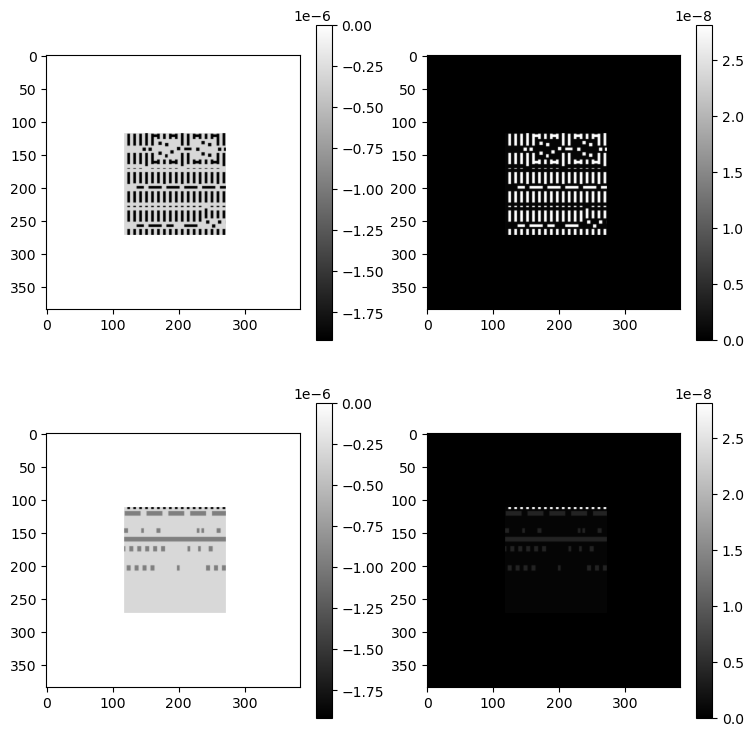

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[49+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[49+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
fig.colorbar(im)

Note that in this formation delta is negative

## Create a solver class for tomography

In [5]:
tslv = holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [6]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

In [7]:
Ru = tslv.fwd_tomo_batch(u)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [8]:
psi = pslv.exptomo(Ru)
# Ru0=pslv.logtomo(psi)
# print(np.linalg.norm(Ru-Ru0))

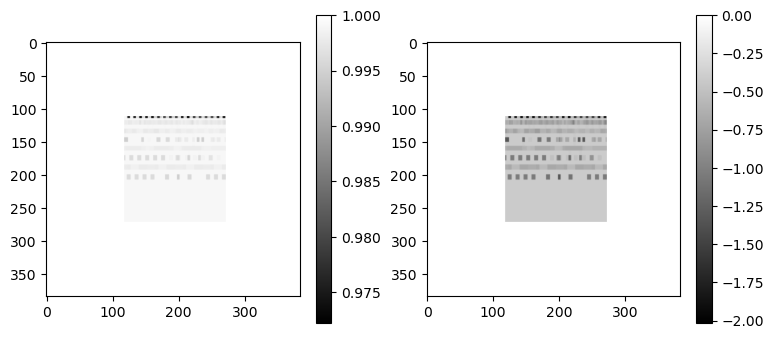

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
fig.colorbar(im)

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [10]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')
prb = prb_abs*np.exp(1j*prb_phase)  
prb[:] = prb[0]

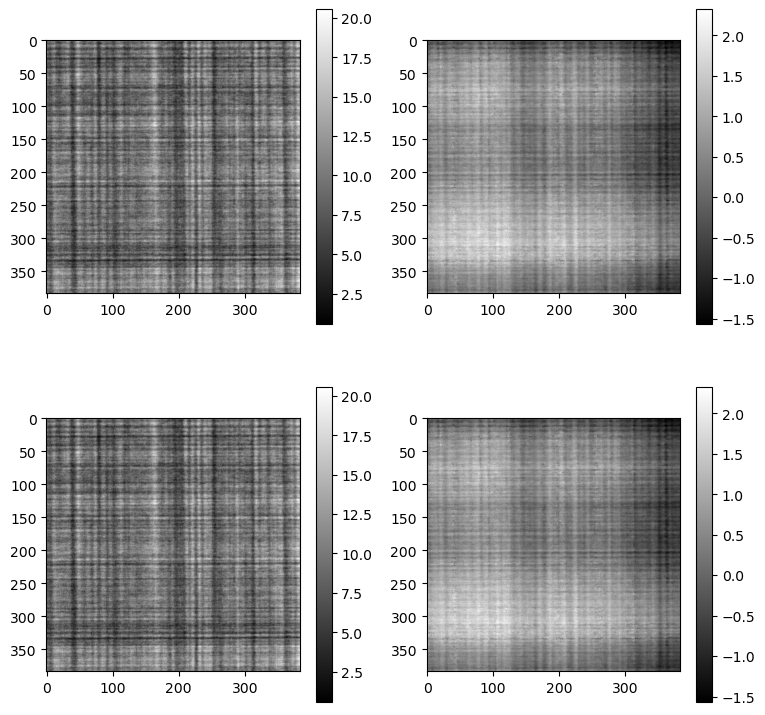

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray')
fig.colorbar(im)

# Structured illuminations

ill_feature_size=8.533333333333332e-05cm
(4, 384, 384)


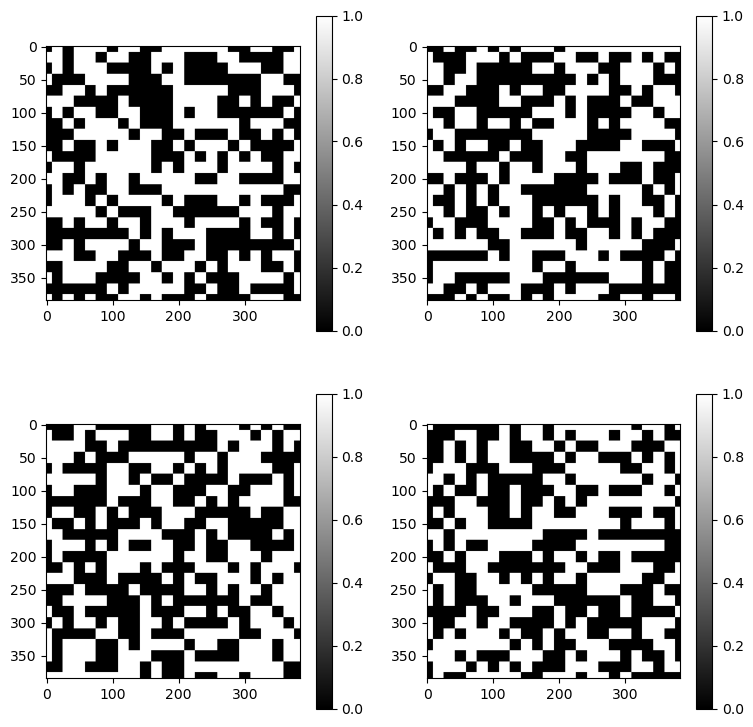

In [12]:
import random
import scipy.ndimage as ndimage
nill = n//16
ill_feature_size = n/nill*voxelsize

print(f'{ill_feature_size=}cm')


ill = np.zeros([4,nill,nill],dtype=np.int32)
for k in  range(ill.shape[0]):
    ill0 = np.zeros([nill*nill],dtype=np.int32)
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill[k] = ill0.reshape(nill,nill)
ill = ndimage.zoom(ill,[1,n/nill,n/nill],order=0)
print(ill.shape)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ill[0],cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(ill[1],cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(ill[2],cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(ill[3],cmap='gray')
fig.colorbar(im)


In [13]:
import xraylib
delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
thickness = 10*1e-2/voxelsize # thickness in pixels
# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / pslv.wavelength()) 

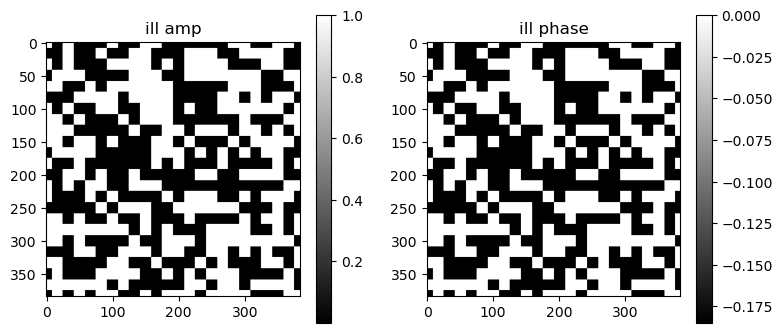

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('ill amp')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('ill phase')
fig.colorbar(im)



# Multiply probe by illuminations

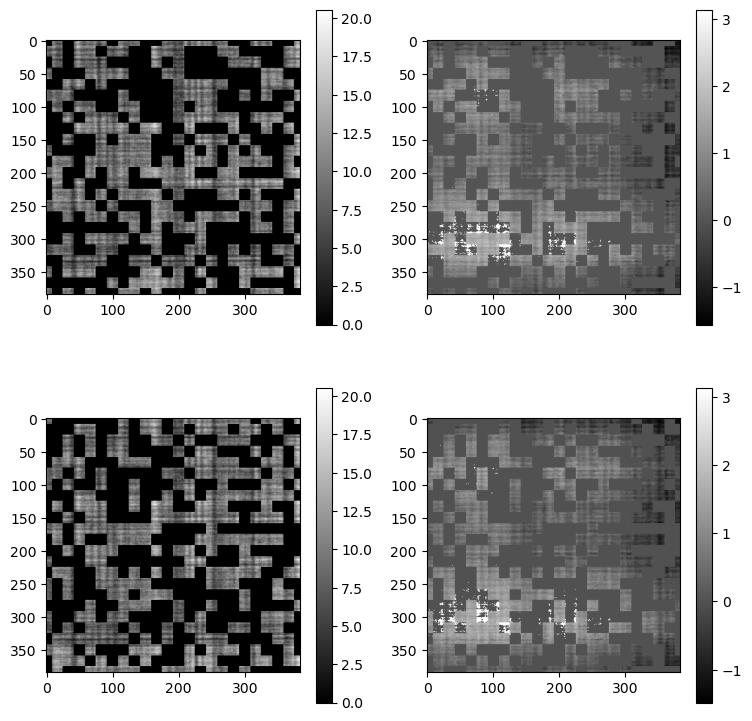

In [15]:
prb = prb*ill
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray')
fig.colorbar(im)

# Compute holographic projections for all angles and all distances

In [16]:
fpsi = pslv.fwd_holo_batch(psi,prb)

## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [17]:
data = np.abs(fpsi)**2

# !!!Note that simple flat-field correction creates artifacts!!! Demonstration:

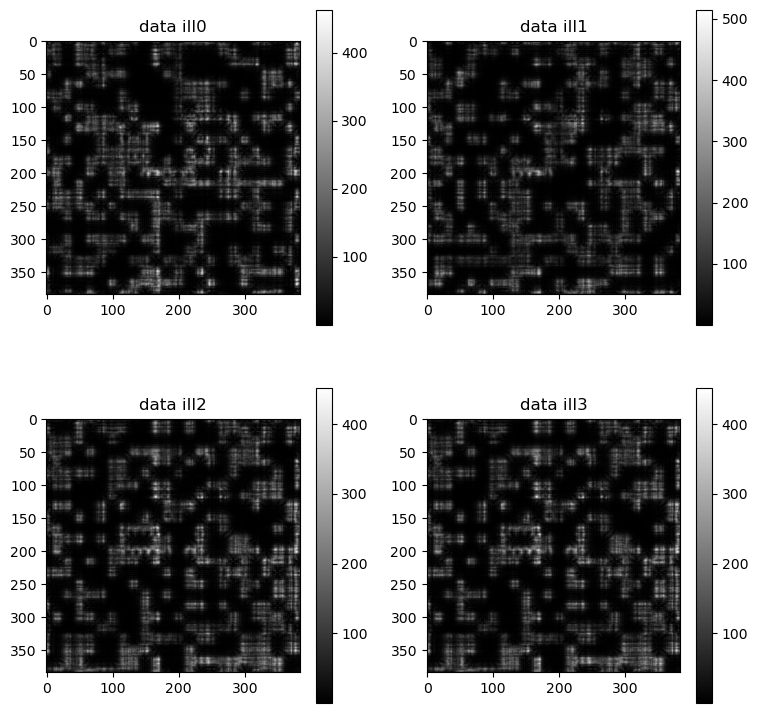

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data ill0')
fig.colorbar(im)

im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data ill1')
fig.colorbar(im)

im=axs[1,0].imshow(data[2,0],cmap='gray')
axs[1,0].set_title('data ill2')
fig.colorbar(im)

im=axs[1,1].imshow(data[2,0],cmap='gray')
axs[1,1].set_title('data ill3')
fig.colorbar(im)


# Save data nd flat fields

In [ ]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_chip_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(flat[k,0],f'data/modeling/flat_chip_{n}_{k}',overwrite=True)